In [9]:
import matplotlib.pyplot as plt
import numpy as np


symmray_data = {6: [(4,0.023), (6,0.045), (8, 0.072), (10, 0.277), (12, 0.717)], 4: [(4,0.006), (6,0.006), (8, 0.007), (10, 0.007), (20, 0.046), (30, 0.455)]}
pyblock3_data = {6: [(4,0.010), (6,0.020), (8, 0.082), (10, 0.325), (12, 1.133)], 4: [(4,0.002), (6,0.003), (8, 0.004), (10, 0.006), (20, 0.077), (30, 0.576)]}

symmray_data_approx = {6: [(4,0.052), (6,0.057), (8, 0.063), (10, 0.077), (12, 0.117)], 4: [(4,0.016), (6,0.017), (8, 0.019), (10, 0.020), (20, 0.235), (30, 2.529)]}
pyblock3_data_approx = {6: [(4,0.063), (6,0.067), (8, 0.076), (10, 0.092), (12, 0.134)], 4: [(4,0.023), (6,0.020), (8, 0.025), (10, 0.030), (20, 0.452), (30, 4.877)]}

Text(0.5, 0.98, 'Square $L \\times L$ amp Z2 fPEPS, exact contraction')

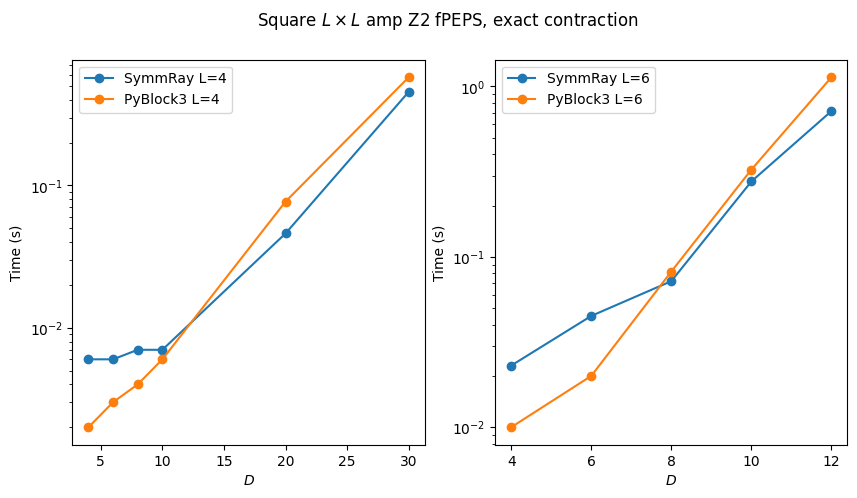

In [22]:
# plot and compare the two data sets
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for L, data in symmray_data.items():
    x, y = zip(*data)
    if L == 4:
        ax[0].plot(x, y, label=f"SymmRay L={L}", marker='o', linestyle='-')
    else:
        ax[1].plot(x, y, label=f"SymmRay L={L}", marker='o', linestyle='-')
for L, data in pyblock3_data.items():
    x, y = zip(*data)
    if L == 4:
        ax[0].plot(x, y, label=f"PyBlock3 L={L}", marker='o', linestyle='-')
    else:
        ax[1].plot(x, y, label=f"PyBlock3 L={L}", marker='o', linestyle='-')

ax[0].set_xlabel(r'$D$')
ax[0].set_ylabel('Time (s)')
ax[1].set_xlabel(r'$D$')
ax[1].set_ylabel('Time (s)')
# ax.set_ylabel('Time (s)')
ax[0].legend()
ax[1].legend()
ax[0].set_yscale('log')
ax[1].set_yscale('log')
fig.suptitle(r'Square $L \times L$ amp Z2 fPEPS, exact contraction')

Text(0.5, 0.98, 'Square $L \\times L$ amp Z2 fPEPS, approximate contraction ($\\chi=D$)')

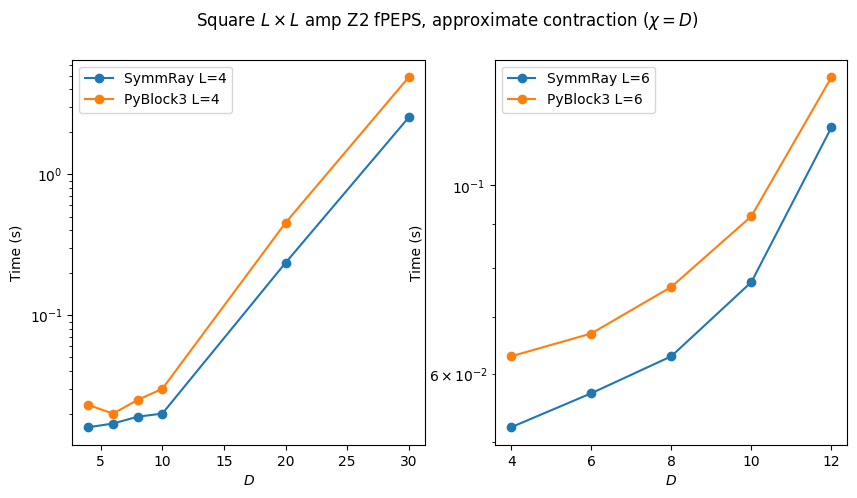

In [23]:
# plot and compare the two data sets
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for L, data in symmray_data_approx.items():
    x, y = zip(*data)
    if L == 4:
        ax[0].plot(x, y, label=f"SymmRay L={L}", marker='o', linestyle='-')
    else:
        ax[1].plot(x, y, label=f"SymmRay L={L}", marker='o', linestyle='-')
for L, data in pyblock3_data_approx.items():
    x, y = zip(*data)
    if L == 4:
        ax[0].plot(x, y, label=f"PyBlock3 L={L}", marker='o', linestyle='-')
    else:
        ax[1].plot(x, y, label=f"PyBlock3 L={L}", marker='o', linestyle='-')

ax[0].set_xlabel(r'$D$')
ax[0].set_ylabel('Time (s)')
ax[1].set_xlabel(r'$D$')
ax[1].set_ylabel('Time (s)')
# ax.set_ylabel('Time (s)')
ax[0].legend()
ax[1].legend()
ax[0].set_yscale('log')
ax[1].set_yscale('log')
fig.suptitle(r'Square $L \times L$ amp Z2 fPEPS, approximate contraction ($\chi=D$)')

In [6]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ["OMP_NUM_THREADS"] = '1'
import warnings
warnings.filterwarnings("ignore")
from mpi4py import MPI
import pickle
pwd = '/home/sijingdu/TNVMC/VMC_code/vmc_torch/data'
# torch
import torch
torch.autograd.set_detect_anomaly(False)

# quimb
import quimb.tensor as qtn
import autoray as ar

from vmc_torch.experiment.tn_model import *
from vmc_torch.sampler import MetropolisExchangeSamplerSpinful, MetropolisMPSSamplerSpinful
from vmc_torch.variational_state import Variational_State
from vmc_torch.optimizer import SGD, SR,Adam, SGD_momentum, DecayScheduler, TrivialPreconditioner
from vmc_torch.VMC import VMC
from vmc_torch.hamiltonian import spinful_Fermi_Hubbard_square_lattice
from vmc_torch.hamiltonian_torch import spinful_Fermi_Hubbard_square_lattice_torch
from vmc_torch.torch_utils import SVD,QR

# Register safe SVD and QR functions to torch
ar.register_function('torch','linalg.svd',SVD.apply)
ar.register_function('torch','linalg.qr',QR.apply)

from vmc_torch.global_var import DEBUG
from vmc_torch.utils import closest_divisible


COMM = MPI.COMM_WORLD
SIZE = COMM.Get_size()
RANK = COMM.Get_rank()

# Hamiltonian parameters
Lx = int(6)
Ly = int(6)
symmetry = 'Z2'
t = 1.0
U = 8.0
# N_f = int(Lx*Ly-8)
N_f = int(Lx*Ly)
n_fermions_per_spin = (N_f//2, N_f//2)
H = spinful_Fermi_Hubbard_square_lattice_torch(Lx, Ly, t, U, N_f, pbc=False, n_fermions_per_spin=n_fermions_per_spin)
graph = H.graph
# TN parameters
D = 8
chi = -1
dtype=torch.float64

# # Load PEPS
skeleton = pickle.load(open(pwd+f"/{Lx}x{Ly}/t={t}_U={U}/N={N_f}/{symmetry}/D={D}/peps_skeleton.pkl", "rb"))
peps_params = pickle.load(open(pwd+f"/{Lx}x{Ly}/t={t}_U={U}/N={N_f}/{symmetry}/D={D}/peps_su_params.pkl", "rb"))
peps = qtn.unpack(peps_params, skeleton)
peps.apply_to_arrays(lambda x: torch.tensor(x, dtype=dtype))

# VMC sample size
N_samples = int(10)
N_samples = closest_divisible(N_samples, SIZE)
if (N_samples/SIZE)%2 != 0:
    N_samples += SIZE

nn_hidden_dim = Lx*Ly
model = fTNModel(peps, max_bond=chi, dtype=dtype)
random_state = torch.tensor(H.hilbert.random_state())

# Set up sampler
sampler = MetropolisExchangeSamplerSpinful(H.hilbert, graph, N_samples=N_samples, burn_in_steps=2, reset_chain=False, random_edge=False, equal_partition=True, dtype=dtype, subchain_length=10)
# Set up variational state
variational_state = Variational_State(model, hi=H.hilbert, sampler=sampler, dtype=dtype)
model(random_state)

F=8.74 C=8.95 S=18.00 P=19.67: 100%|██████████| 10/10 [00:00<00:00, 221.83it/s]


tensor([1.3623e-18], dtype=torch.float64, grad_fn=<StackBackward0>)

In [ ]:
random_configs = []
for _ in range(60):
    random_configs.append(H.hilbert.random_state())

random_configs = torch.tensor(random_configs)

import pyinstrument

# batched calculation
with pyinstrument.Profiler() as profiler:
    variational_state.amplitude(random_configs)
profiler.print()

# single calculation
with pyinstrument.Profiler() as profiler:
    for config in random_configs:
        variational_state.amplitude(config)
profiler.print()


  _     ._   __/__   _ _  _  _ _/_   Recorded: 13:54:03  Samples:  5226
 /_//_/// /_\ / //_// / //_'/ //     Duration: 5.767     CPU time: 5.767
/   _/                      v5.0.1

Profile at /tmp/ipykernel_3918/2905716282.py:10

5.766 <module>  /tmp/ipykernel_3918/2905716282.py:1
└─ 5.766 wrapper  ../../utils.py:39
   └─ 5.766 Variational_State.amplitude  ../../variational_state.py:91
      └─ 5.766 fTNModel._wrapped_call_impl  torch/nn/modules/module.py:1735
         └─ 5.766 fTNModel._call_impl  torch/nn/modules/module.py:1743
            └─ 5.766 fTNModel.forward  ../tn_model.py:93
               └─ 5.766 fTNModel.amplitude  ../tn_model.py:1094
                  ├─ 5.339 PEPS.contract  quimb/tensor/tensor_core.py:8934
                  │     [48 frames hidden]  functools, quimb, cotengra, symmray, ...
                  └─ 0.419 fPEPS.get_amp  ../../fermion_utils.py:158
                     └─ 0.418 fPEPS.get_amp_efficient  ../../fermion_utils.py:185
                        ├─ 0.15

: 

In [39]:
import pyinstrument

with pyinstrument.Profiler() as profiler:
    model(random_state)

profiler.print(show_all=True)


  _     ._   __/__   _ _  _  _ _/_   Recorded: 03:47:06  Samples:  287
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.289     CPU time: 0.290
/   _/                      v5.0.1

Profile at /tmp/ipykernel_19942/3873722178.py:3

0.288 <module>  /tmp/ipykernel_19942/3873722178.py:1
└─ 0.288 fTNModel._wrapped_call_impl  torch/nn/modules/module.py:1735
   └─ 0.288 fTNModel._call_impl  torch/nn/modules/module.py:1743
      └─ 0.288 fTNModel.forward  ../tn_model.py:534
         └─ 0.288 fTNModel.amplitude  ../tn_model.py:969
            ├─ 0.128 PEPS.contract_boundary_from_ymax  quimb/tensor/tensor_2d.py:2140
            │  └─ 0.128 PEPS.contract_boundary_from  quimb/tensor/tensor_2d.py:1714
            │     ├─ 0.127 PEPS._contract_boundary_core  quimb/tensor/tensor_2d.py:1315
            │     │  ├─ 0.070 PEPS.canonize_plane  quimb/tensor/tensor_2d.py:913
            │     │  │  └─ 0.070 PEPS.canonize_between  quimb/tensor/tensor_core.py:6697
            │     │  │     └─ 0.070 PEPS._can

Text(0.5, 1.0, 'Symmray: $(4 \\times L)$ Z2-fPEPS (D=4) amp, exact contraction time')

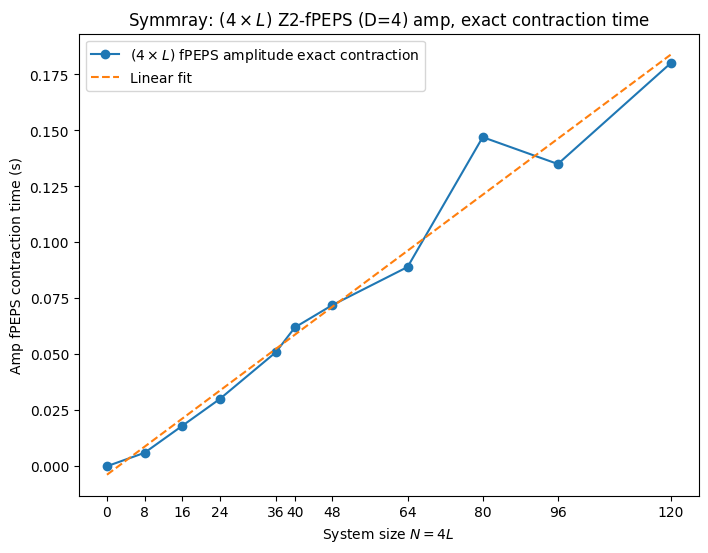

In [2]:
time_N = {0:0, 8: 0.006, 16:0.018, 24:0.030, 36:0.051, 40:0.062, 48:0.072, 64:0.089, 80:0.147, 96:0.135, 120:0.180}
time_N_boundary = {0:0, 8: 0.007, 16:0.045, 24:0.126, 36:0.144, 48:0.268, 64:0.385, 80:0.507, 100:0.624, 120:0.833}
import matplotlib.pyplot as plt
import numpy as np
# plot and compare the two data sets
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
N = [n for n in list(time_N.keys())]
time = list(time_N.values())
N_boundary = list(time_N_boundary.keys())
time_boundary = list(time_N_boundary.values())
ax.plot(N, time, label=r'$(4 \times L)$ fPEPS amplitude exact contraction', marker='o', linestyle='-')
# ax.plot(N_boundary, time_boundary, label='Boundary contraction', marker='o', linestyle='-')
plt.xlabel(r'System size $N=4L$')
plt.xticks(N)
plt.ylabel('Amp fPEPS contraction time (s)')
 
# linear fit for exacrt contraction
from scipy.stats import linregress
x = np.array(list(time_N.keys())[:])
y = np.array(list(time_N.values())[:])
slope, intercept, r_value, p_value, std_err = linregress(x, y)
x_range = np.linspace(0, max(N), 100)
ax.plot(x_range, slope*x_range + intercept, label='Linear fit', linestyle='--')
ax.legend()

# # linear fit for boundary contraction
# x = np.array(list(time_N_boundary.keys())[:])
# y = np.array(list(time_N_boundary.values())[:])
# slope, intercept, r_value, p_value, std_err = linregress(x, y)
# x_range = np.linspace(0, 120, 100)
# ax.plot(x_range, slope*x_range + intercept, label='Linear fit boundary', linestyle='--')
# ax.legend()

# # quadratic fit for exact contraction
from scipy.optimize import curve_fit
def quadratic(x, a, b, c):
    return a*x**2 + b*x + c
# x = np.array(list(time_N.keys()))
# y = np.array(list(time_N.values()))
# popt, pcov = curve_fit(quadratic, x, y)
# x_range = np.linspace(0, 100, 100)
# ax.plot(x_range, quadratic(x_range, *popt), label='Quadratic fit', linestyle='--')
# ax.legend()

# # quadratic fit for boundary contraction
# x = np.array(list(time_N_boundary.keys()))
# y = np.array(list(time_N_boundary.values()))
# popt, pcov = curve_fit(quadratic, x, y)
# x_range = np.linspace(0, 120, 100)
# ax.plot(x_range, quadratic(x_range, *popt), label='Quadratic fit boundary', linestyle='--')
# ax.legend()
plt.title(r'Symmray: $(4 \times L)$ Z2-fPEPS (D=4) amp, exact contraction time')

0.02188547004335839 [[1.12473303e-07]]


Text(0.5, 1.0, '$(4 \\times L)$ fPEPS, $D=4$')

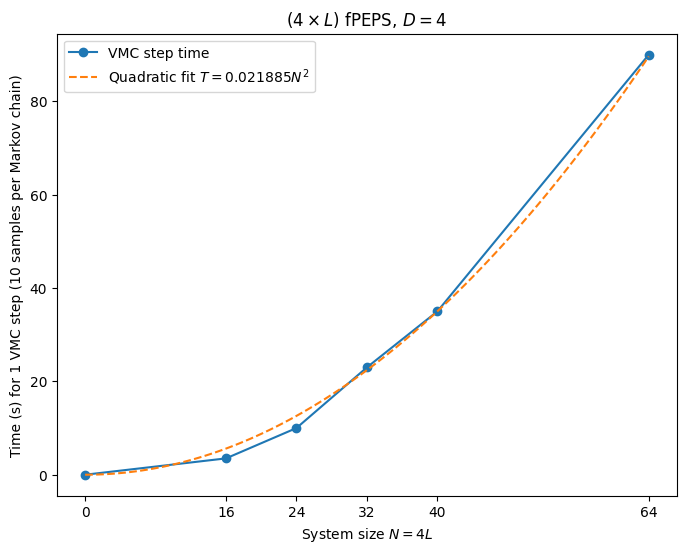

In [3]:
size_vmc_step_time = {0:0, 16: 3.5, 24:10, 32: 23, 40:35, 64: 90}

# plot
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
N = list(size_vmc_step_time.keys())
time = list(size_vmc_step_time.values())
ax.plot(N, time, label='VMC step time', marker='o', linestyle='-')

# quadratic fit for exact contraction
from scipy.optimize import curve_fit
def quadratic(x, a):
    return a*x**2
x = np.array(list(size_vmc_step_time.keys()))
y = np.array(list(size_vmc_step_time.values()))
popt, pcov = curve_fit(quadratic, x, y)
print(*popt, pcov)
x_range = np.linspace(0, max(N), 100)

ax.plot(x_range, quadratic(x_range, *popt), label=r'Quadratic fit $T=0.021885N^2$', linestyle='--')
ax.legend()

plt.xticks(N)
# plt.yticks(time)
plt.xlabel(r'System size $N=4L$')
plt.ylabel('Time (s) for 1 VMC step (10 samples per Markov chain)')
plt.title(r'$(4 \times L)$ fPEPS, $D=4$')

0.029631083202511732 [[1.70023023e-07]]


Text(0.5, 1.0, '$(4 \\times L)$ fPEPS+NN, $D=4$')

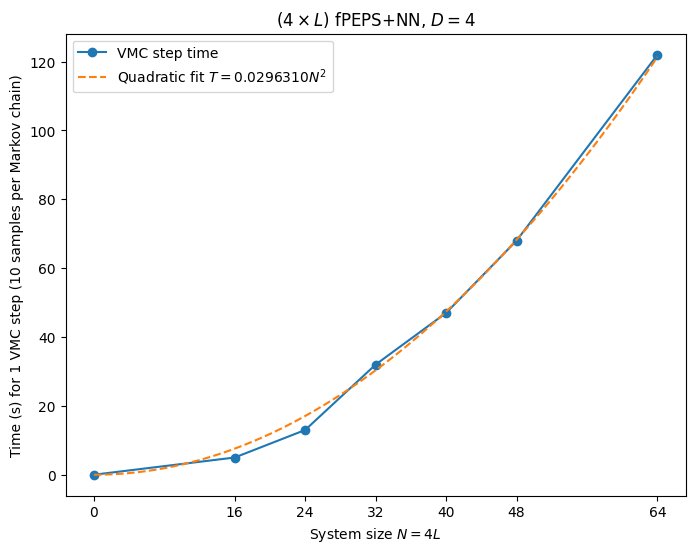

In [4]:
size_vmc_step_time = {0:0, 16: 5, 24:13, 32: 32, 40:47, 48:68, 64:122}

# plot
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
N = list(size_vmc_step_time.keys())
time = list(size_vmc_step_time.values())
ax.plot(N, time, label='VMC step time', marker='o', linestyle='-')

# quadratic fit for exact contraction
from scipy.optimize import curve_fit
def quadratic(x, a):
    return a*x**2
x = np.array(list(size_vmc_step_time.keys()))
y = np.array(list(size_vmc_step_time.values()))
popt, pcov = curve_fit(quadratic, x, y)
print(*popt, pcov)
x_range = np.linspace(0, max(N), 100)

ax.plot(x_range, quadratic(x_range, *popt), label=r'Quadratic fit $T=0.0296310N^2$', linestyle='--')
ax.legend()

plt.xticks(N)
# plt.yticks(time)
plt.xlabel(r'System size $N=4L$')
plt.ylabel('Time (s) for 1 VMC step (10 samples per Markov chain)')
plt.title(r'$(4 \times L)$ fPEPS+NN, $D=4$')

Text(0.5, 1.0, '$(4 \\times 16)$ fPEPS+NN, $D=4$')

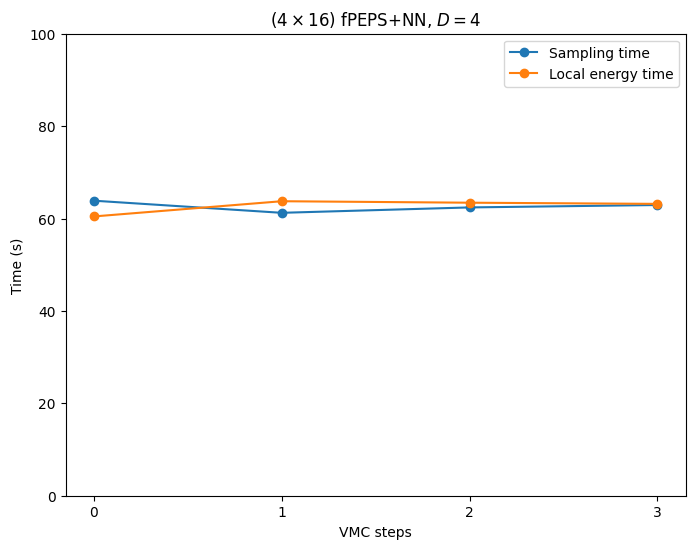

In [46]:
step_time = {0:(63.86, 60.45), 1: (61.235, 63.743783), 2:(62.4019420, 63.42356), 3:(62.922735, 63.1722866)}

import matplotlib.pyplot as plt
import numpy as np
# plot and compare the two data sets
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
steps = [n for n in list(step_time.keys())]
time_sampler = [t[0] for t in list(step_time.values())]
time_local_E = [t[1] for t in list(step_time.values())]
ax.plot(steps, time_sampler, label='Sampling time', marker='o', linestyle='-')
ax.plot(steps, time_local_E, label='Local energy time', marker='o', linestyle='-')
plt.xlabel(r'VMC steps')
plt.xticks(steps)
plt.ylabel('Time (s)')
plt.ylim(0, 100)
plt.legend()
plt.title(r'$(4 \times 16)$ fPEPS+NN, $D=4$')